In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm
from skimage import exposure


Loaded image: 1 with shape (770, 730, 3)
Loaded image: 2 with shape (770, 733, 3)
Loaded image: 3 with shape (770, 733, 3)
Loaded image: 4 with shape (770, 769, 3)
Loaded image: 5 with shape (770, 769, 3)
Loaded image: 6 with shape (770, 769, 3)
Successfully loaded 6 images
1


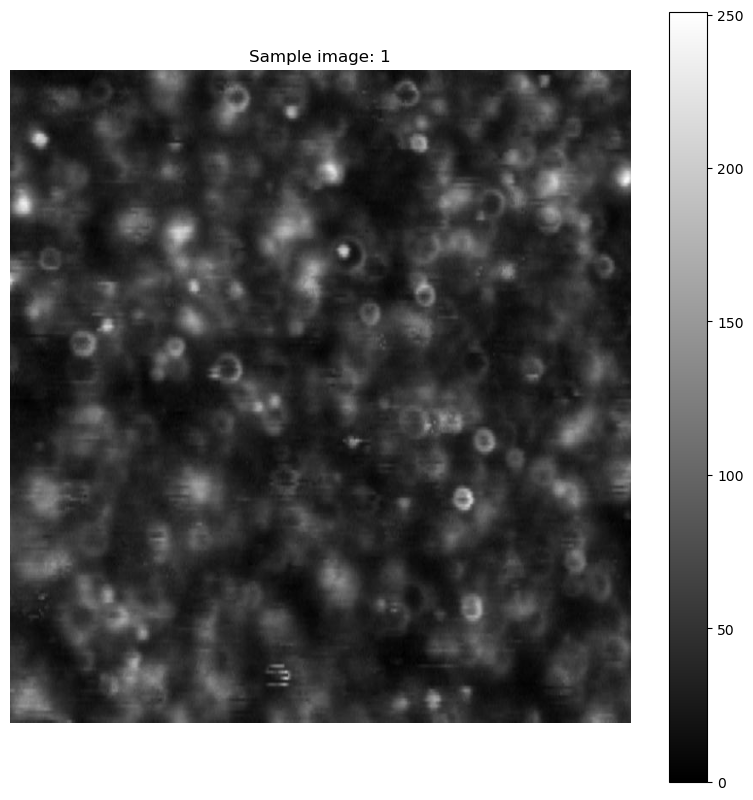

In [ ]:
# Define directory path where images are stored
image_dir = 'jpeg versions' 

# Dictionary to store the images
trap_images = {}

# Check if the directory exists
if os.path.exists(image_dir):
    # List all files in the directory
    files = os.listdir(image_dir)
    
    # Filter for .sxm files (assuming they have common image extensions)
    ext = '.jpeg'
    image_files = [f for f in files if f.lower().endswith(ext)]
    
    # Load each image into the dictionary
    for img_file in image_files:
        # Read the image
        img_path = os.path.join(image_dir, img_file)
        try:
            # Open image
            img = plt.imread(img_path)
            # Use filename without extension as the key
            key = os.path.splitext(img_file)[0]
            trap_images[key] = img
            print(f"Loaded image: {key} with shape {img.shape}")
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
    
    print(f"Successfully loaded {len(trap_images)} images")
else:
    print(f"Directory {image_dir} does not exist")

# Display a sample image if any were loaded
if trap_images:
    # Pick first image to display
    sample_key = next(iter(trap_images))
    print(sample_key)
    plt.figure(figsize=(10, 10))
    plt.imshow(trap_images[sample_key], cmap='gray')
    plt.title(f"Sample image: {sample_key}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [2]:
# noise functions

def add_line_noise(image, num_lines_range=(10, 50), segment_length_range=(5, 50), noise_range=(-0.3, 0.3)):
    """
    Add random line noise to an image by modifying random segments of random lines.
    
    Args:
        image: 2D numpy array representing the image
        num_lines_range: Tuple of (min, max) number of lines to modify
        segment_length_range: Tuple of (min, max) length of continuous segments
        noise_range: Tuple of (min, max) noise values to add
    
    Returns:
        Modified image with line noise
    """
    # Make a copy to avoid modifying the original
    noisy_image = image.copy()
    height, width = image.shape
    
    # Choose random number of lines to modify
    num_lines = random.randint(*num_lines_range)
    
    # For each line
    for _ in range(num_lines):
        # Choose random line
        line_idx = random.randint(0, height-1)
        
        # Choose random starting point and length for the segment
        segment_length = random.randint(*segment_length_range)
        start_idx = random.randint(0, width - segment_length)
        
        # Generate random noise value
        noise_value = random.uniform(*noise_range)
        
        # Add noise to the segment
        noisy_image[line_idx, start_idx:start_idx+segment_length] += noise_value
    
    # Clip values to valid range [0, 1]
    return np.clip(noisy_image, 0, 1)

def add_gaussian_noise(image, mean=0, std=0.05):
    """
    Add Gaussian noise to an image.
    
    Args:
        image: Input image as a numpy array
        mean: Mean of the Gaussian noise (default: 0)
        std: Standard deviation of the Gaussian noise (default: 0.05)
        
    Returns:
        Noisy image
    """
    # Generate Gaussian noise with the same shape as the input image
    noise = np.random.normal(mean, std, image.shape)
    
    # Add noise to the image
    noisy_image = image + noise
    
    # Clip values to ensure they stay in valid range [0, 1]
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

def add_rolling_lines(image, n_lines=10, roll_range=(1, 5)):
    """
    Add randomly positi oned horizontal lines, roll them by random amounts,
    and crop the image to remove roll-over artifacts.
    
    Args:
        image: Input image (numpy array)
        n_lines: Number of lines to add
        roll_range: Range for random roll amount (min, max)
        
    Returns:
        Modified image with rolled lines and cropped edges
    """
    # Make a copy of the input image
    result = image.copy()
    height, width = image.shape
    
    # Track the maximum roll amount used
    max_roll = 0
    
    for _ in range(n_lines):
        # Create a line at random y position
        y_pos = random.randint(0, height-1)
        
        # Get the line
        line = result[y_pos, :].copy()
        
        # Roll the line by random amount
        roll_amount = random.randint(*roll_range)
        max_roll = max(max_roll, roll_amount)
        rolled_line = np.roll(line, roll_amount)
        
        # Put the rolled line back
        result[y_pos, :] = rolled_line
    
    # Crop the image to remove roll-over artifacts
    if max_roll > 0:
        result = result[max_roll:-max_roll, max_roll:-max_roll]
    
    return result

def match_histograms(generated_img, reference_img):
    """
    Match the histogram of the generated image to the reference image.
    
    Args:
        generated_img: The generated image with high contrast
        reference_img: A representative real image with desired contrast
        
    Returns:
        Adjusted generated image with contrast matching the reference
    """
    # Convert to grayscale if needed for histogram matching
    if len(generated_img.shape) == 3 and len(reference_img.shape) == 3:
        # Match each channel separately for color images
        matched = np.zeros_like(generated_img)
        for i in range(3):  # RGB channels
            matched[:,:,i] = exposure.match_histograms(
                generated_img[:,:,i], 
                reference_img[:,:,i]
            )
        return matched
    else:
        # For grayscale
        return exposure.match_histograms(generated_img, reference_img)


In [3]:
def generate_synthetic_data(n, num_donuts_range_max=(5, 50), num_donuts_range_min = (1,10), num_circles_range=(3, 25), 
                          radius_range_circle=(5, 10), radius_range_donuts=(10,30), 
                          thickness_range=(2, 5), intensity_range_init=(0.2, 0.5),
                          intensity_range_2 = (0.3,1),
                          gaussian_sigma_range=(0.5, 5.0)):
    """
    Generate synthetic data with filtered donuts and circles of varying intensities.
    Also returns bounding box coordinates for each donut.
    
    Args:
        n: Resolution of the square image
        num_donuts_range: Range for number of donuts
        num_circles_range: Range for number of circles
        radius_range_circle: Range for circle radii
        radius_range_donuts: Range for donut radii
        thickness_range: Range for donut thickness
        intensity_range: Range for shape intensities
        gaussian_sigma_range: Range for Gaussian filter sigma
    
    Returns:
        synthetic_img: Generated synthetic image
        donut_boxes: List of dicts with bounding box coordinates for each donut
                    [{'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}, ...]
    """
    synthetic_img = np.zeros((n, n), dtype=float)
    synthetic_img = add_gaussian_noise(synthetic_img, mean=0, std=0.25)
    
    p = random.random()
    if p < 0.5:
        num_donuts = random.randint(*num_donuts_range_max)
    else:
        num_donuts = random.randint(*num_donuts_range_min)

    num_circles = random.randint(*num_circles_range)
    
   # print(f"Generating synthetic data with {num_donuts} donuts and {num_circles} circles")

    # List to store bounding box coordinates for donuts
    donut_boxes = []
    
    def apply_random_filter(layer,sigma=None):  
        if sigma is None:
            # Randomly choose between Gaussian and median filter
            sigma = random.uniform(*gaussian_sigma_range)
        return cv2.GaussianBlur(layer, (0, 0), sigma)
    
    # Add filtered circles for background
    for _ in range(1000):
        circle_layer = np.zeros((n, n), dtype=float)
        
        center = (random.randint(0, n-1), random.randint(0, n-1))
        radius = random.randint(*radius_range_circle)
        intensity = random.uniform(*intensity_range_init)
        
        # Draw and filter circle
        cv2.circle(circle_layer, center, radius, intensity, -1)
        filtered_circle = apply_random_filter(circle_layer)#, sigma=10)
        
        synthetic_img = np.maximum(synthetic_img,filtered_circle)

    # Apply gaussian filter to whole image
    synthetic_img = cv2.GaussianBlur(synthetic_img, (0, 0), random.uniform(7,8))

    # Add donuts with filtering and save bounding boxes
    for _ in range(num_donuts):
        donut_layer = np.zeros((n, n), dtype=float)
        
        center_x = random.randint(0, n-1)
        center_y = random.randint(0, n-1)
        center = (center_x, center_y)
        
        outer_radius = random.randint(*radius_range_donuts)
      #  print('radius:', outer_radius)
        thickness = random.randint(*thickness_range)
      #  print('thickness:', thickness)
        
        inner_radius = max(outer_radius - thickness, 1)
        intensity = random.uniform(*intensity_range_2)
        
        # Calculate bounding box coordinates
        x1 = max(0, center_x - outer_radius)
        y1 = max(0, center_y - outer_radius)
        x2 = min(n-1, center_x + outer_radius)
        y2 = min(n-1, center_y + outer_radius)
        
        # Save bounding box
        donut_boxes.append({
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'center_x': center_x,
            'center_y': center_y,
            'outer_radius': outer_radius,
            'inner_radius': inner_radius
        })
        
        # Draw donut
        cv2.circle(donut_layer, center, outer_radius, intensity, -1)
        cv2.circle(donut_layer, center, inner_radius, 0.0, -1)
        
        # Apply random filter
        filtered_donut = apply_random_filter(donut_layer)
        
        # Ensure hole remains transparent
        hole_mask = np.zeros_like(donut_layer)
        cv2.circle(hole_mask, center, inner_radius, 1.0, -1)
        filtered_donut[hole_mask > 0] = 0.0
        
        synthetic_img = synthetic_img + filtered_donut
    
    # Add filtered circles
    for _ in range(num_circles):
        circle_layer = np.zeros((n, n), dtype=float)
        
        center = (random.randint(0, n-1), random.randint(0, n-1))
        radius = random.randint(*radius_range_circle)
        intensity = random.uniform(*intensity_range_2)
        
        # Draw and filter circle
        cv2.circle(circle_layer, center, radius, intensity, -1)
        filtered_circle = apply_random_filter(circle_layer)
        
        synthetic_img = np.maximum(synthetic_img, filtered_circle)

    # Apply gaussian filter to whole image
    synthetic_img = cv2.GaussianBlur(synthetic_img, (0, 0), random.uniform(3,6))

    return synthetic_img, donut_boxes

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


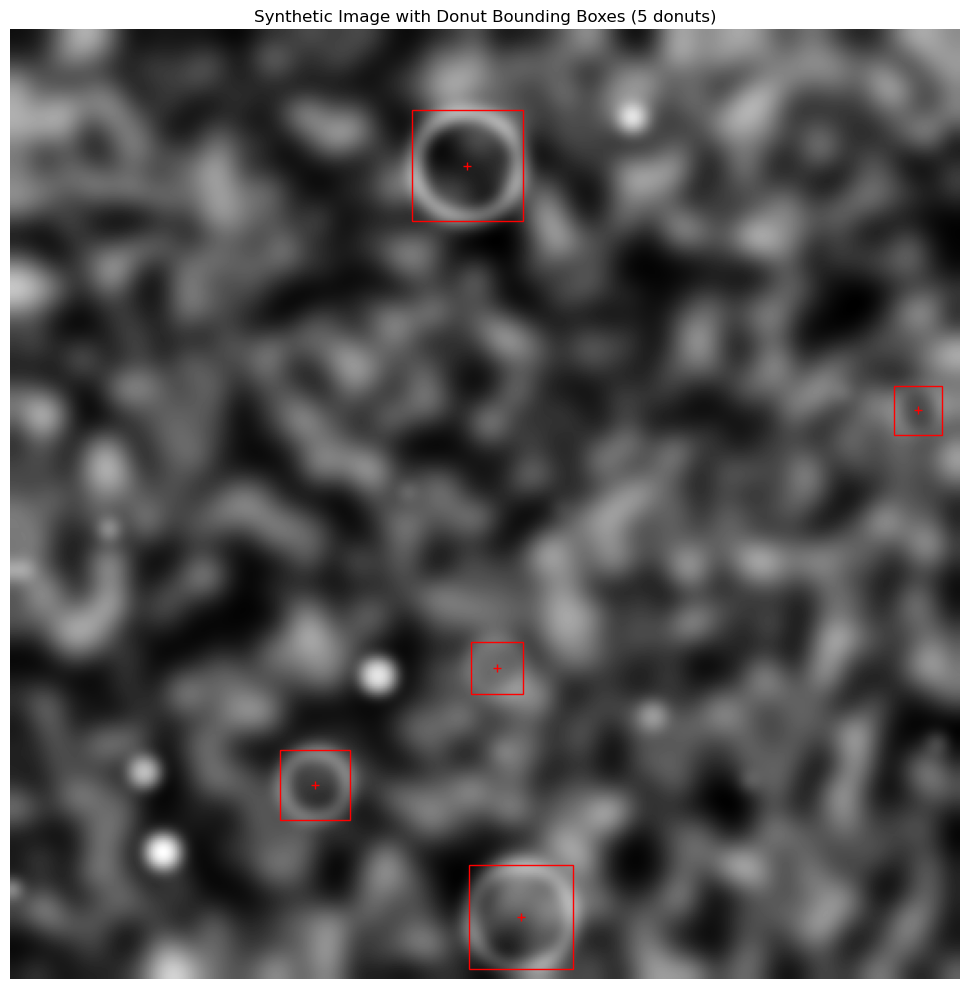

Donut 1:
  Bounding box: (216, 43) to (276, 103)
  Center: (246, 73)
  Outer radius: 30, Inner radius: 25
Donut 2:
  Bounding box: (248, 330) to (276, 358)
  Center: (262, 344)
  Outer radius: 14, Inner radius: 12
Donut 3:
  Bounding box: (476, 192) to (502, 218)
  Center: (489, 205)
  Outer radius: 13, Inner radius: 11
Donut 4:
  Bounding box: (145, 388) to (183, 426)
  Center: (164, 407)
  Outer radius: 19, Inner radius: 15
Donut 5:
  Bounding box: (247, 450) to (303, 506)
  Center: (275, 478)
  Outer radius: 28, Inner radius: 25


In [5]:
# Generate synthetic image with donut bounding boxes without noise to see the initial structure
n = 512
synthetic, donut_boxes = generate_synthetic_data(n,   
                          thickness_range=(2, 5), intensity_range_init=(0.2, 0.5),
                          intensity_range_2 = (0.3,0.5))

#print(synthetic.shape)
# Visualize image and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(synthetic, cmap='gray')

# Draw bounding boxes
for box in donut_boxes:
    # Create rectangle patch
    x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
    width = x2 - x1
    height = y2 - y1
    
    # Draw rectangle
    rect = plt.Rectangle((x1, y1), width, height, 
                         fill=False, edgecolor='red', linewidth=1)
    plt.gca().add_patch(rect)
    
    # Optionally, draw center point
    plt.plot(box['center_x'], box['center_y'], 'r+')

plt.title(f'Synthetic Image with Donut Bounding Boxes ({len(donut_boxes)} donuts)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print bounding box information for first 5 donuts
for i, box in enumerate(donut_boxes[:5]):
    print(f"Donut {i+1}:")
    print(f"  Bounding box: ({box['x1']}, {box['y1']}) to ({box['x2']}, {box['y2']})")
    print(f"  Center: ({box['center_x']}, {box['center_y']})")
    print(f"  Outer radius: {box['outer_radius']}, Inner radius: {box['inner_radius']}")

In [ ]:
# Generate dataset and save as numpy arrays
# We first generate the clean images then add noise and augmentations

def generate_dataset(num_images=5000, image_size=512):
    '''
    Function to generate a dataset of synthetic images with donuts and circles,
    split into training and validation sets, and save them as numpy arrays.
    It saves the images and their corresponding annotations to cwd/synthetic_data/numpy_arrays'
    and cwd/synthetic_data/annotations.
    Args:
        num_images: Total number of synthetic images to generate
        image_size: Size of the square images (image_size x image_size)
    Returns:
        train_size: Number of training images generated
        val_size: Number of validation images generated
    '''
    # Split indices for train/val
    indices = list(range(num_images))
    random.shuffle(indices)
    train_size = int(0.8 * num_images)
    train_indices = set(indices[:train_size])
    val_indices = set(indices[train_size:])
    
    # Initialize arrays to store images
    train_images = np.zeros((train_size, image_size, image_size), dtype=np.float32)
    val_images = np.zeros((num_images - train_size, image_size, image_size), dtype=np.float32)
    
    # Dictionaries to store annotations
    train_annotations = []
    val_annotations = []
    
    train_idx = 0
    val_idx = 0
    
    print(f"Generating {num_images} synthetic images...")
    for i in tqdm(range(num_images)):
        # Generate synthetic image with rolled lines
        n = image_size + 10
        # Generate synthetic image with bounding boxes
        synthetic, donut_boxes = generate_synthetic_data(n, num_circles_range=(10, 60), num_donuts_range_max=(50, 300),
                                                        num_donuts_range_min=(10,25),
                                                        radius_range_circle=(5, 15), radius_range_donuts=(4,20), 
                                                        thickness_range=(2, 4))
        synthetic_with_line_noise = add_line_noise(synthetic, num_lines_range=(50, 200), segment_length_range=(5, 50), noise_range=(-0.7, 0.6))
        synthetic_with_noise = add_gaussian_noise(synthetic_with_line_noise, mean=0, std=0.1)
        synthetic_with_noise = cv2.GaussianBlur(synthetic_with_noise, (0, 0), random.uniform(1,3))
        synthetic_with_roll_with_noise = add_rolling_lines(synthetic_with_noise, n_lines=400, roll_range=(1, 5))
        image = cv2.GaussianBlur(synthetic_with_roll_with_noise, (0, 0), random.uniform(1,2))

        image = add_gaussian_noise(image, mean=0, std=0.001)

        
        contrast_like = random.choice(list(trap_images.keys()))
        image = match_histograms(image, trap_images[contrast_like][:,:,0])

        # Add image and annotations to appropriate arrays
        if i in train_indices:
          #  print(image.shape)
            train_images[train_idx] = image
            train_annotations.append({
                'image_id': train_idx,
                'boxes': donut_boxes
            })
            train_idx += 1
        else:
            val_images[val_idx] = image
            val_annotations.append({
                'image_id': val_idx,
                'boxes': donut_boxes
            })
            val_idx += 1
    
    # check to see directories exist, if not make them

    # Check if directories exist, if not create them
    os.makedirs('synthetic_data/numpy_arrays', exist_ok=True)
    os.makedirs('synthetic_data/annotations', exist_ok=True)

    # Save arrays
    np.save('synthetic_data/numpy_arrays/train_images.npy', train_images)
    np.save('synthetic_data/numpy_arrays/val_images.npy', val_images)
    
    # Save annotations
    with open('synthetic_data/annotations/train_annotations.json', 'w') as f:
        json.dump(train_annotations, f)
    with open('synthetic_data/annotations/val_annotations.json', 'w') as f:
        json.dump(val_annotations, f)
    
    print(f"Generated {train_size} training images and {num_images - train_size} validation images")
    print(f"Train array shape: {train_images.shape}")
    print(f"Val array shape: {val_images.shape}")
    return train_size, num_images - train_size


Generating 5 synthetic images...


100%|██████████| 5/5 [01:13<00:00, 14.76s/it]

Generated 4 training images and 1 validation images
Train array shape: (4, 640, 640)
Val array shape: (1, 640, 640)
